In [ ]:
#!pip install python-crfsuite
!pip install sklearn-pycrfsuite

In [ ]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [ ]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [ ]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")

In [ ]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [ ]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

    

In [ ]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [ ]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=[],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [ ]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [ ]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    words, biotags = zip(*example) # unpack example, turn it into word and BIO tag.
    posttagger = CRFTagger() # initialise postagger
    posttagger.set_model_file("crf_pos.tagger")
    words_postags = posttagger.tag(words) # tag the words

    w, postags = zip(*words_postags) # unpack words and postags
    w = list(w) # convert words into a list
    postags = list(postags) # convert postags into a list
    postags = ["@" + tag for tag in postags] # add @ to the postags

    w_pos = [i + j for i, j in zip(w, postags)] # add POSTAG to the word.
    biotags = list(biotags) # convert biotags to list

    # STICK THE BIOTAG BACK ON IT
    w_pos_bio = list(zip(w_pos, biotags)) # turn the word with POSTAG and BIO tag into a new tuple.

    preprocessed_example = w_pos_bio  
    return preprocessed_example

In [ ]:
training_data = [preProcess(example) for example in raw_training_data]

In [ ]:
# check the effect of pre-processing
print(training_data[0])

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')]


In [ ]:
# Train test split on training_data.

# print(training_data[0][1][0])

first_80 = round(len(training_data) * 0.8)

training = training_data[0:first_80]
development = training_data[first_80:]

print(len(training))
print(len(development))


6253
1563


In [ ]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits
import time
# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    tokens_length = len(tokens)

    word_postag = token.split("@") # Split the word
    token = word_postag[0] # token = word

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    #-------Q5----------#
    if len(token) > 4: # Added suffix up to length 4.
      feature_list.append("SUF_" + token[-4:])

    feature_list.append("WORD_" + token)
    feature_list.append("POSTAG_" + word_postag[1])

    if idx > 0: # Q5 - add previous word, previous postag as features, check to make sure its 2nd word in the sentence.
      prevtoken = tokens[idx-1]
      prevword_prevpostag = prevtoken.split("@")
      feature_list.append("PREVWORD_" + prevword_prevpostag[0])
      feature_list.append("PREVPOSTAG_" + prevword_prevpostag[1])

    if idx > 1: # Q5 - add word/postag before previous word, previous postag as features, check to make sure its 3nd word in the sentence.
      prevtoken = tokens[idx-2]
      prevword_prevpostag = prevtoken.split("@")
      feature_list.append("PREVWORD2_" + prevword_prevpostag[0])
      feature_list.append("PREVPOSTAG2_" + prevword_prevpostag[1])

    # Prefix up to length 3

    if len(token) > 1:
        feature_list.append("PREF_" + token[0])
    if len(token) > 2:
        feature_list.append("PREF_" + token[0:2])
    if len(token) > 3:
        feature_list.append("PREF_" + token[0:3])

    # THESE DID NOT IMPROVE THE SCORE.

    # Prefix to length 4:

    # if len(token) > 4:
    #     feature_list.append("PREF_" + token[0:4])

    # Next word, next postag:

    # if idx < tokens_length-1:
    #   next_token = tokens[idx+1]
    #   next_token_pos = next_token.split("@")
    #   feature_list.append("NEXTWORD_" + next_token_pos[0])
    #   feature_list.append("NEXTPOSTAG_" + next_token_pos[1])

    # 2 words forward, 2 postags forward:

    # if idx < tokens_length-2:
    #   next_token = tokens[idx+2]
    #   next_token_pos = next_token.split("@")
    #   feature_list.append("NEXTWORD2_" + next_token_pos[0])
    #   feature_list.append("NEXTPOSTAG2_" + next_token_pos[1])

    return feature_list

In [ ]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"c1":0.4, "c2":0.61, "feature.minfreq":0})  # initialize tagger with get_features function

print("training tagger...")
ct.train(training, TAGGER_PATH)
print("done")

training tagger...
done


In [ ]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
print(len(development), "instances")
print(sum([len(sent) for sent in development]), "words")

1563 instances
31282 words


In [ ]:
print("testing tagger...")
print()
preds = []
y_test = []
fp_count = 0 # Counter is used for full counts of FP for a given class
fn_count = 0 # Counter is used for full counts of FN for a given class
low_prec_class = "I-Opinion" # Classes with low precision are: B-Soundtrack, I-Soundtrack, I-Opinion, B-Opinion, B-Plot
low_recall_class = "I-Soundtrack" # Classes with low recall are: I-Soundtrack, B-Soundtrack, I-Opinion, I-Character_Name, B-Quote

# For each sentence in development set
for sent in development:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])] # Tagging the word in sentence. 
    sent_true = [s[1] for s in sent] # The true tags 
    preds.extend(sent_preds) # Add the predictions to preds
    y_test.extend(sent_true) # Add the true tags to y_test

    # # Change the low_prec_class and low_recall_class variable to a different class to find out the FP/FN for that class.

    # #----------------------FALSE POSITIVES--------------------------#

    for p, t in zip(sent_preds, sent_true):
      # If the prediction is equal to the given class, and the true label is not equal to the given class
      if p == low_prec_class and t != low_prec_class: # change both to == for true positives
      # Print the sentence, true tag, and prediction with some formatting
        print("FP:")
        print("SENTENCE: ", ' '.join([x[0] for x in sent])) 
        print("TRUE TAG: ", ', '.join([x[1] for x in sent]))
        print("PREDICTION: ", ', '.join(sent_preds))
        print()
        fp_count = fp_count+1 # counter for number of FP
        break # Break to only print each sentence once as soon as the first FP of the sentence is found. Remove the break if you want full counts of FP.

    # #----------------------FALSE NEGATIVES--------------------------#

    # for p, t in zip(sent_preds, sent_true):
    #   if p != low_recall_class and t == low_recall_class:
    #     # If the prediction is not equal to the given class, and the true label is equal to the given class
    #   # Print the sentence, true tag, and prediction with some formatting
    #     print("FN:")
    #     print("SENTENCE: ", ' '.join([x[0] for x in sent]))
    #     print("TRUE TAG: ", ', '.join([x[1] for x in sent]))
    #     print("PREDICTION: ", ', '.join(sent_preds))
    #     print()
    #     fn_count = fn_count+1 # counter for number of false negatives
    #     break # Break to only print each sentence once as soon as the first FN of the sentence is found. Remove the break if you want full counts of FP.
        
print("done")

# print("Number of sentences which have a FP/FN. Comment out the break in each loop for number of words with FP/FN.")
# print("FP count:", fp_count)
# print("FN count:", fn_count)

testing tagger...

FP:
SENTENCE:  this@DT computer@NN animated@JJ comedy@NN features@NNS the@DT voice@NN of@IN steve@NNP carrell@NNP as@IN the@DT villainous@JJ but@CC likeable@JJ gru@NN
TRUE TAG:  O, B-Genre, I-Genre, I-Genre, O, O, O, O, B-Actor, I-Actor, O, O, O, O, O, B-Character_Name
PREDICTION:  O, B-Genre, I-Genre, I-Genre, O, O, O, O, B-Actor, I-Actor, O, O, B-Opinion, I-Opinion, I-Opinion, I-Opinion

FP:
SENTENCE:  this@DT fun@NN bird@NN watching@VBG comedy@NN from@IN 2011@NNP stars@NNP jack@NNP black@NNP owen@NNP wilson@NNP and@CC steve@NNP martin@NNP
TRUE TAG:  O, O, O, O, B-Genre, O, B-Year, O, B-Actor, I-Actor, I-Actor, I-Actor, O, B-Actor, I-Actor
PREDICTION:  O, B-Opinion, I-Opinion, I-Opinion, B-Genre, O, B-Year, O, B-Actor, I-Actor, I-Actor, I-Actor, O, B-Actor, I-Actor

FP:
SENTENCE:  this@DT movie@NN features@NNS a@DT boat@NN who@WP was@VBD commonly@RB thought@VBD to@TO be@VB too@RB large@JJ to@TO sink@VB but@CC still@RB did@VBD
TRUE TAG:  O, O, O, B-Plot, I-Plot, I-P

In [ ]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.91      0.94      0.92      1229
         B-Award       0.77      0.68      0.72        74
B-Character_Name       0.77      0.41      0.53       212
      B-Director       0.92      0.80      0.85       472
         B-Genre       0.87      0.84      0.85       805
       B-Opinion       0.54      0.32      0.40       160
        B-Origin       0.60      0.50      0.55       159
          B-Plot       0.52      0.48      0.50      1219
         B-Quote       0.82      0.38      0.51        24
  B-Relationship       0.80      0.51      0.62       125
    B-Soundtrack       0.75      0.46      0.57        13
          B-Year       0.98      0.99      0.98       702
         I-Actor       0.91      0.94      0.92      1729
         I-Award       0.79      0.82      0.80       202
I-Character_Name       0.80      0.43      0.56       165
      I-Director       0.93      0.78      0.84       456
         I-Ge

MACRO AVERGAGE F1 SCORE: **0.68**

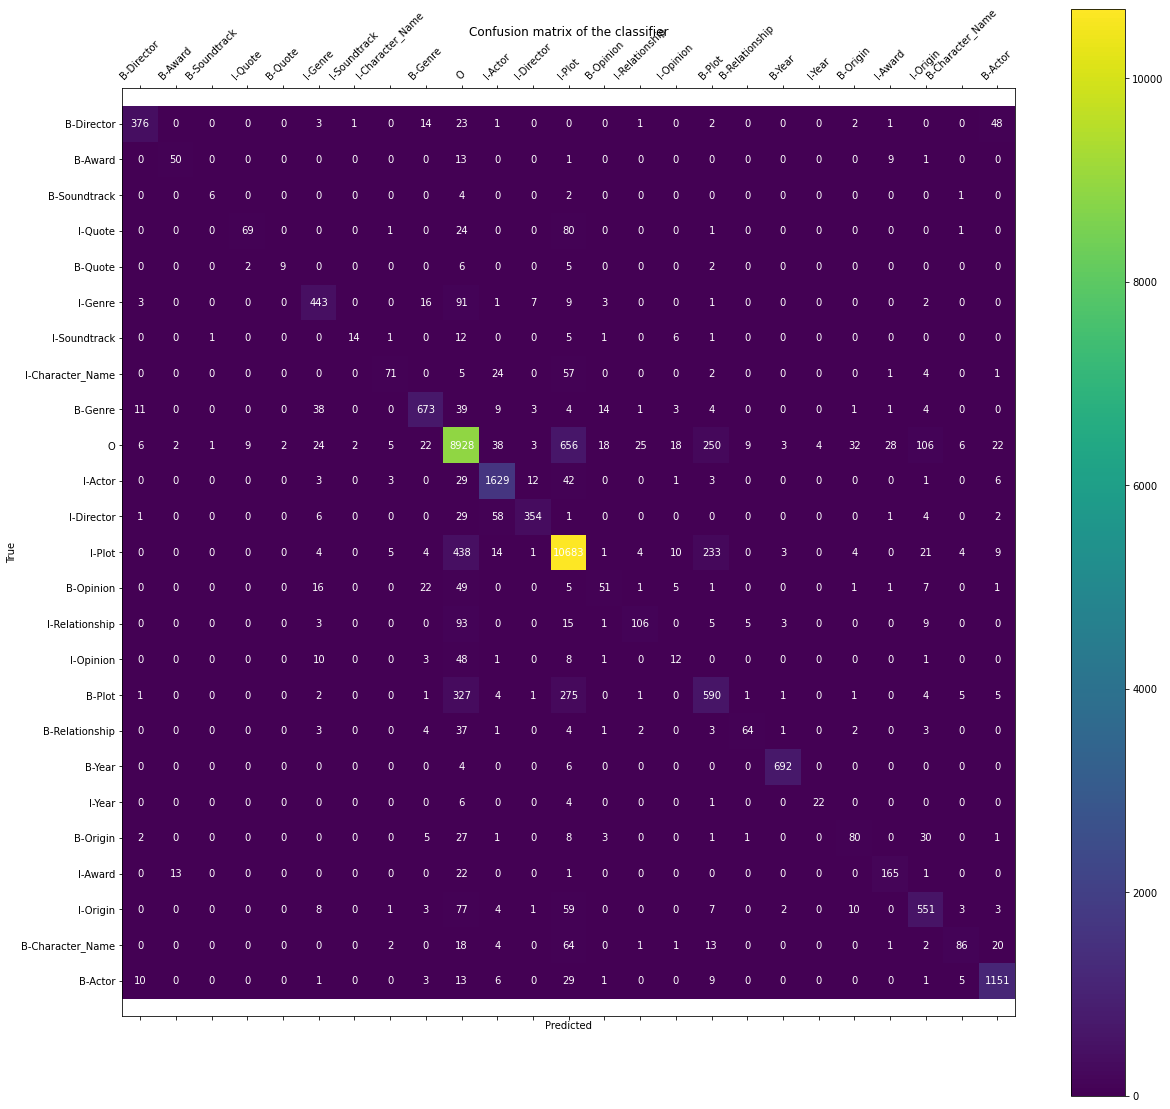

In [ ]:
confusion_matrix_heatmap(y_test, preds)

In [ ]:
print_transition_weights(ct._tagger.info().transitions.items())

In [ ]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

In [ ]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"c1":0.4, "c2":0.61, "feature.minfreq":0})  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [ ]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.91      0.93      0.92      1274
         B-Award       0.70      0.70      0.70        66
B-Character_Name       0.70      0.44      0.54       283
      B-Director       0.87      0.85      0.86       425
         B-Genre       0.84      0.79      0.81       789
       B-Opinion       0.46      0.40      0.43       195
        B-Origin       0.46      0.37      0.41       190
          B-Plot       0.52      0.49      0.51      1577
         B-Quote       0.81      0.36      0.50        47
  B-Relationship       0.81      0.57      0.67       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.96      0.97      0.97       661
         I-Actor       0.90      0.93      0.92      1553
         I-Award       0.77      0.73      0.75       147
I-Character_Name       0.73      0.51      0.60       227
      I-Director       0.91      0.86      0.88       411
         I-Ge

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MACRO AVERAGE F1 SCORE ON FINAL TEST SET: **0.63**